# Análise de Ocorrências Aeronáuticas no Brasil (2010 - 2021)

Dataset: https://www.kaggle.com/datasets/nosbielcs/opendataaigbrazil/data

Autores: Arthur Pedroso Porto Belli, Gabrielly Ferreira Gama

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

In [2]:
data = pd.read_csv('accidents_clean_csv.csv')

In [3]:
data.head()

,codigo_ocorrencia,ocorrencia_classificacao,ocorrencia_tipo,ocorrencia_dia,ocorrencia_horario,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,aeronave_matricula,...,aeronave_ano_fabricacao,aeronave_pais_registro,aeronave_categoria_registro,aeronave_segmento_aviacao,aeronave_origem_voo,aeronave_destino_voo,aeronave_fase_voo,aeronave_tipo_operacao,aeronave_nivel_dano,quantidade_fatalidades
0,201211159478138,ACIDENTE,FALHA DO MOTOR EM VOO,2012-11-15,12:40:00,ABADIA DE GOIÁS,GO,BRASIL,****,PPZGV,...,1985,BRASIL,PET,EXPERIMENTAL,****,****,MANOBRA,VOO EXPERIMENTAL,2,0
1,200912289948837,ACIDENTE,PERDA DE CONTROLE EM VOO,2009-12-28,17:30:00,ACEGUÁ,RS,BRASIL,****,PRSUB,...,1973,BRASIL,SAE,ESPECIALIZADA,****,****,DECOLAGEM,OPERAÇÃO ESPECIALIZADA,2,1
2,201209091794314,ACIDENTE,PERDA DE CONTROLE EM VOO,2012-09-09,20:00:00,ACREÚNA,GO,BRASIL,****,PRGFD,...,1979,BRASIL,TPP,PARTICULAR,****,****,DECOLAGEM,VOO PRIVADO,3,4
3,200905218704582,INCIDENTE,FALHA DO MOTOR EM VOO,2009-05-21,10:33:00,ADAMANTINA,SP,BRASIL,****,PTDVP,...,1971,BRASIL,TPP,PARTICULAR,****,****,CRUZEIRO,VOO PRIVADO,0,0
4,200811106021664,ACIDENTE,POUSO EM LOCAL NÃO PREVISTO,2008-11-10,17:00:00,ADOLFO,SP,BRASIL,****,PTEXO,...,1979,BRASIL,TPP,PARTICULAR,****,****,POUSO,VOO PRIVADO,2,0


O dataset contém 4.774 registros e 27 colunas, muitas das quais são categóricas. A variável de interesse para a predição é ```aeronave_nivel_dano```, que é representada como um valor numérico. Codificação numérica do atributo "aeronave_nivel_dano".

NENHUM = 0  
LEVE = 1  
SUBSTANCIAL = 2  
DESTRUÍDA = 3  

In [4]:
# Seleção de colunas relevantes
# Mantemos variáveis que podem ter relação com o nível de dano da aeronave e são significativas para o modelo
relevant_columns = [
    "ocorrencia_classificacao",
    "ocorrencia_tipo",
    "aeronave_tipo_motor",
    "aeronave_quantidade_motores",
    "aeronave_peso_maximo_decolagem",
    "aeronave_quantidade_assentos_passageiros",
    "aeronave_ano_fabricacao",
    "aeronave_categoria_registro",
    "aeronave_segmento_aviacao",
    "aeronave_fase_voo",
    "quantidade_fatalidades",
    "aeronave_nivel_dano",
]

data_filtered = data[relevant_columns]

# Verificar valores únicos e tipos de dados para preparar a codificação
data_filtered.nunique(), data_filtered.isnull().sum()


(ocorrencia_classificacao                      3
 ocorrencia_tipo                              59
 aeronave_tipo_motor                           6
 aeronave_quantidade_motores                   5
 aeronave_peso_maximo_decolagem              437
 aeronave_quantidade_assentos_passageiros     85
 aeronave_ano_fabricacao                      76
 aeronave_categoria_registro                  31
 aeronave_segmento_aviacao                    13
 aeronave_fase_voo                            30
 quantidade_fatalidades                       13
 aeronave_nivel_dano                           4
 dtype: int64,
 ocorrencia_classificacao                    0
 ocorrencia_tipo                             0
 aeronave_tipo_motor                         0
 aeronave_quantidade_motores                 0
 aeronave_peso_maximo_decolagem              0
 aeronave_quantidade_assentos_passageiros    0
 aeronave_ano_fabricacao                     0
 aeronave_categoria_registro                 0
 aeronave_segmento_av

In [6]:
# Separar as features e o target
X = data_filtered.drop(columns=["aeronave_nivel_dano"])
y = data_filtered["aeronave_nivel_dano"]

# Codificar variáveis categóricas
categorical_columns = X.select_dtypes(include=["object"]).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col in categorical_columns:
    X[col] = label_encoders[col].fit_transform(X[col])

# Normalizar variáveis numéricas
numerical_columns = X.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3819, 11), (955, 11), (3819,), (955,))

In [7]:
# Treinar um modelo SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = svm_model.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

print(accuracy)
print(classification_report_output)

0.6973821989528796
              precision    recall  f1-score   support

           0       0.70      0.84      0.76       362
           1       0.54      0.40      0.46       253
           2       0.81      0.77      0.79       280
           3       0.68      0.73      0.70        60

    accuracy                           0.70       955
   macro avg       0.68      0.69      0.68       955
weighted avg       0.69      0.70      0.69       955



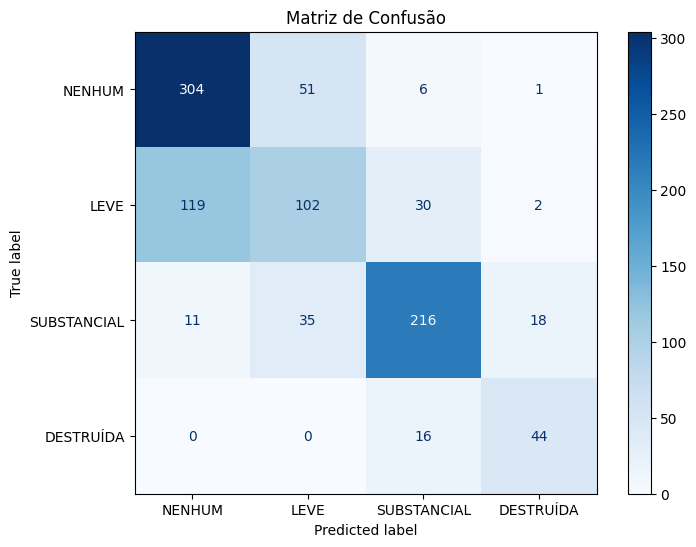

In [8]:
# Codificação para os níveis de dano
nivel_dano_dict = {0: "NENHUM", 1: "LEVE", 2: "SUBSTANCIAL", 3: "DESTRUÍDA"}

# Gerar matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Converter os rótulos para os nomes codificados
class_names = [nivel_dano_dict[i] for i in sorted(nivel_dano_dict.keys())]

# Criar a visualização da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Visualizar matriz de confusão
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Matriz de Confusão")
plt.show()


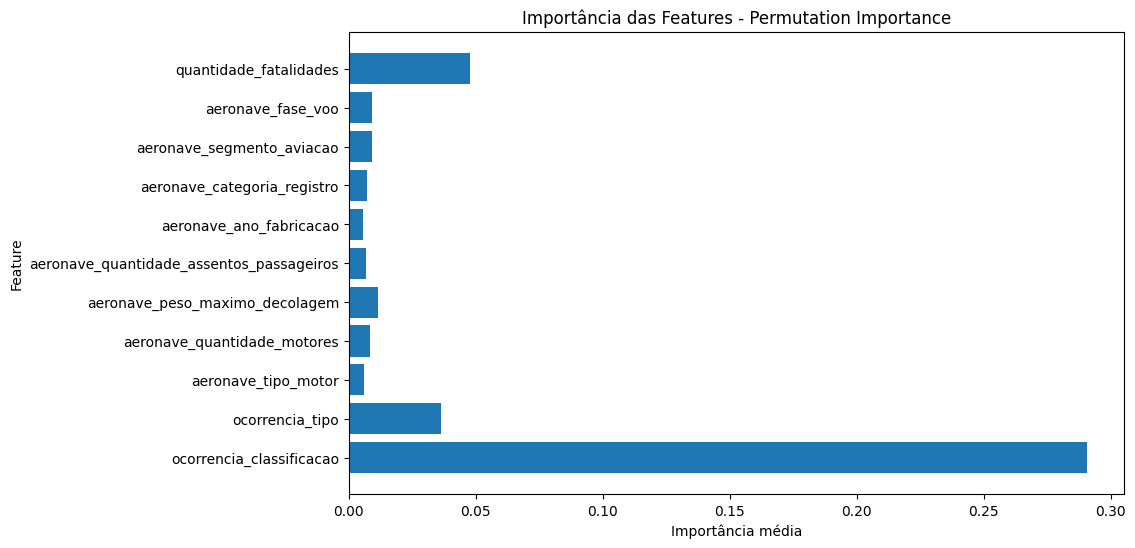

In [9]:
# Realizar a permutação para medir a importância das features
result = permutation_importance(svm_model, X_test, y_test, n_repeats=10, random_state=42)

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns, result.importances_mean)
plt.title('Importância das Features - Permutation Importance')
plt.xlabel('Importância média')
plt.ylabel('Feature')
plt.show()

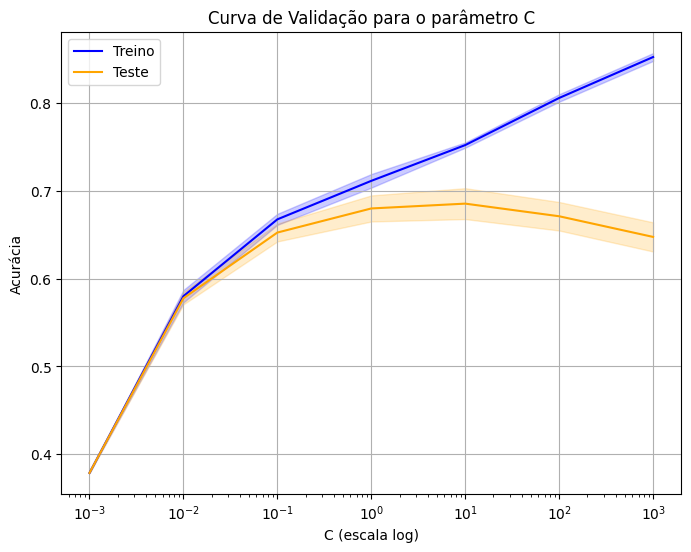

In [10]:
# Curva de validação para o hiperparâmetro C
param_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(
    SVC(kernel='rbf', random_state=42),
    X_train, y_train,
    param_name="C",
    param_range=param_range,
    cv=5,
    scoring="accuracy"
)

# Calcular média e desvio padrão das pontuações
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotar curvas de validação
plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, label="Treino", color="blue")
plt.plot(param_range, test_mean, label="Teste", color="orange")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="orange", alpha=0.2)
plt.xscale("log")
plt.title("Curva de Validação para o parâmetro C")
plt.xlabel("C (escala log)")
plt.ylabel("Acurácia")
plt.legend(loc="best")
plt.grid()
plt.show()
